In [690]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

In [721]:
FEATURE_ID = 66042
source_conn = sqlite3.connect('/Volumes/Samsung_T5/databases/Hela_20A_20R_500-features-1-100000-random-1000-sf-1000.sqlite')
features_df = pd.read_sql_query("select * from peak_correlation where feature_id={}".format(FEATURE_ID), source_conn)
source_conn.close()

In [722]:
source_conn = sqlite3.connect('/Volumes/Samsung_T5/databases/Hela_20A_20R_500-features.sqlite')
feature_df = pd.read_sql_query("select * from features where feature_id={}".format(FEATURE_ID), source_conn)
source_conn.close()
feature_df

,feature_id,base_frame_id,base_cluster_id,charge_state,start_frame,end_frame,quality_score,summed_intensity,scan_lower,scan_upper,mz_lower,mz_upper
0,66042,1137,194,2,1131,1174,1.0,464750,138,156,534.228394,537.751343


In [723]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

Find the precursor in the ms2 feature region

In [724]:
# retrieve the m/z centroid for the feature's base peak
source_conn = sqlite3.connect('/Volumes/Samsung_T5/databases/Hela_20A_20R_500-features-1-100000-random-1000-sf-1000.sqlite')
base_peak_df = pd.read_sql_query("select * from ms1_feature_region_peaks where feature_id={} and peak_id=(select base_peak_id from feature_base_peaks where feature_id={})".format(FEATURE_ID, FEATURE_ID), source_conn)
base_peak_points_df = pd.read_sql_query("select * from summed_ms1_regions where feature_id={} and peak_id=(select base_peak_id from feature_base_peaks where feature_id={}) order by scan ASC, intensity DESC".format(FEATURE_ID, FEATURE_ID), source_conn)
source_conn.close()

In [725]:
base_peak_df

,feature_id,peak_id,centroid_mz,centroid_scan,intensity_sum,scan_upper,scan_lower,std_dev_mz,std_dev_scan,rationale,intensity_max,peak_max_mz,peak_max_scan
0,66042,1,535.751522,146.45294,192902,152,138,0.014138,1.981807,"{""highest intensity point id"": 66}",32965,535.751793,147


In [726]:
lower_mz = float(base_peak_df.centroid_mz - (8 * base_peak_df.std_dev_mz))
upper_mz = float(base_peak_df.centroid_mz + (8 * base_peak_df.std_dev_mz))
lower_mz,upper_mz

(535.6384195838201, 535.8646253416192)

In [727]:
source_conn = sqlite3.connect('/Volumes/Samsung_T5/databases/Hela_20A_20R_500-features-1-100000-random-1000-sf-1000.sqlite')
ms2_precursor_region_points_df = pd.read_sql_query("select * from summed_ms2_regions where (feature_id,peak_id) in (select feature_id,peak_id from ms2_peaks where feature_id={} and centroid_mz>={} and centroid_mz<={} order by intensity) order by peak_id,scan".format(FEATURE_ID, lower_mz, upper_mz), source_conn)
source_conn.close()

In [728]:
base_peak_points_df.drop_duplicates(['scan'], keep='first', inplace=True)

In [729]:
base_peak_points_df

,feature_id,point_id,mz,scan,intensity,number_frames,peak_id
0,66042,1,535.789594,138,169,2,1
1,66042,2,535.787125,139,46,1,1
2,66042,6,535.753736,140,803,6,1
3,66042,8,535.767761,141,3252,9,1
4,66042,19,535.765719,142,3708,9,1
5,66042,27,535.784682,143,3919,6,1
7,66042,35,535.757215,144,11421,12,1
8,66042,45,535.760525,145,24101,12,1
9,66042,54,535.760409,146,30444,12,1
10,66042,66,535.751793,147,32965,12,1


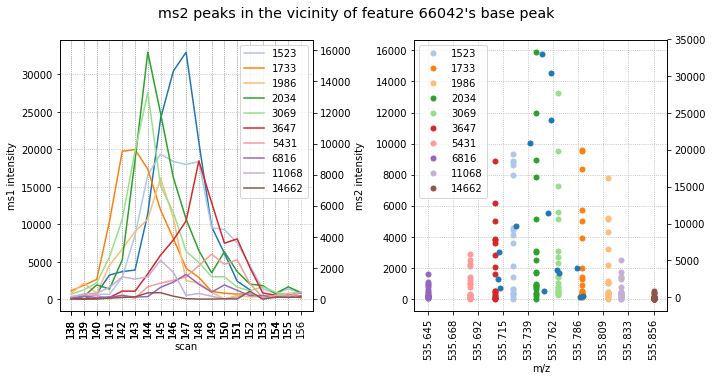

In [730]:
from matplotlib.ticker import FormatStrFormatter

f, (ax1, ax3) = plt.subplots(1, 2, sharey=False, figsize=(10,5))

# ms2 peaks in scan/intensity
scan_range = np.linspace(start=min(ms2_precursor_region_points_df.scan.min(),base_peak_points_df.scan.min()),stop=max(ms2_precursor_region_points_df.scan.max(),base_peak_points_df.scan.max()),dtype=np.int)
ax2 = ax1.twinx()
groups = ms2_precursor_region_points_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax2.plot(group.scan, group.intensity, color=tableau20[i+1 % len(tableau20)], label=name)
ax2.set_ylabel('ms2 intensity')
# ax2.set_xticks(scan_range)
ax2.set_xlabel('scan')
ax2.legend(loc='best')

# base peak in scan/intensity
ax1.plot(base_peak_points_df.scan, base_peak_points_df.intensity)
ax1.set_ylabel('ms1 intensity')
ax1.set_xticks(scan_range)
ax1.set_xlabel('scan')
ax1.set_xticklabels(scan_range, rotation=90)
ax1.grid(linestyle=':')

# ms2 peaks in mz/intensity
mz_range = np.linspace(start=min(ms2_precursor_region_points_df.mz.min(),base_peak_points_df.mz.min()),stop=max(ms2_precursor_region_points_df.mz.max(),base_peak_points_df.mz.max()),num=10)
ax4 = ax3.twinx()
for i, (name, group) in enumerate(groups):
    ax3.plot(group.mz, group.intensity, marker='o', color=tableau20[i+1 % len(tableau20)], linestyle='', ms=5, label=name)
ax3.set_xticks(mz_range)
ax3.set_xticklabels(mz_range, rotation=90)
ax3.set_xlabel('m/z')
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax3.legend(loc='best')
ax3.grid(linestyle=':')

# base peak in mz/intensity
ax4.plot(base_peak_points_df.mz, base_peak_points_df.intensity, marker='o', linestyle='', ms=5, label=name)

st = plt.suptitle("ms2 peaks in the vicinity of feature {}'s base peak".format(FEATURE_ID), fontsize="x-large")
plt.margins(0.06)
plt.tight_layout()
# shift subplots down
st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.show()

Calculating the drift offset by looking for the precursor in the ms2 feature region doesn't look promising because it may not be present if the molecule was fully fragmented (AW says this will happen often). Need to look for another way.

Finding ms2 peaks with their max point within +/- 3 scan of the base peak's max point

In [731]:
base_peak_df.peak_max_scan

0    147
Name: peak_max_scan, dtype: int64

In [ ]:
source_conn = sqlite3.connect('/Volumes/Samsung_T5/databases/Hela_20A_20R_500-features-1-100000-random-1000-sf-1000.sqlite')
# ms2_peak_points_nearby_in_drift_df = pd.read_sql_query("select * from summed_ms2_regions where (feature_id,peak_id) in (select feature_id,peak_id from ms2_peaks where feature_id={} and centroid_mz>={} and centroid_mz<={} order by intensity) order by peak_id,scan".format(FEATURE_ID, lower_mz, upper_mz), source_conn)
ms2_peaks_df = pd.read_sql_query("select * from ms2_peaks where feature_id={}".format(FEATURE_ID), source_conn)
ms2_peaks_df['max_point_scan'] = pd.read_sql_query("select bscan from summed_ms2_regions where feature_id={}".format(FEATURE_ID), source_conn)
source_conn.close()